<a href="https://colab.research.google.com/github/madhumakireddy/cs666student/blob/main/Copy_of_CS666_Assignment_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

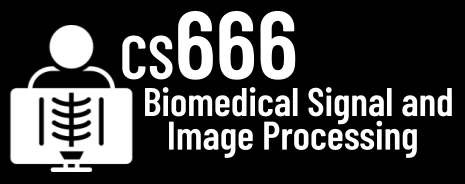
#Assignment 4

In [188]:
# NAME: Madhu sudhana reddy makireddy

In [189]:
# In this assignment, we will create a Random Forest classifier to detect pneumonia and covid in xrays!

In [190]:
# load numpy and matplotlib
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [191]:
# we are using mahotas again, so lets install it!
!pip install mahotas --no-binary :all:

DEPRECATION: --no-binary currently disables reading from the cache of locally built wheels. In the future --no-binary will not influence the wheel cache. pip 23.1 will enforce this behaviour change. A possible replacement is to use the --no-cache-dir option. You can use the flag --use-feature=no-binary-enable-wheel-cache to test the upcoming behaviour. Discussion can be found at https://github.com/pypa/pip/issues/11453
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [192]:
# our imports include sklearn this time
import mahotas as mh
import os
from sklearn.ensemble import RandomForestClassifier

**Task 1:** Download, extract, and load the data! [15 Points]

In [193]:
# Please download this file: https://cs666.org/data/xray/
# This is a subset of the Kaggle Pneumonia + Covid Datasets!
#
# TODO: Upload xray.zip using the file panel on the left.

In [194]:
# Run this code to extract the zip file and to create
# the folder structure of normal/, pneumonia/, and covid/ images.
# Each folder contains the first images of the Kaggle datasets.
import zipfile
with zipfile.ZipFile('xray.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

NORMAL_DIR = 'normal/'
PNEUMONIA_DIR = 'pneumonia/'
COVID_DIR = 'covid/'

In [195]:
# Here we load the first image from the normal dataset.
img = mh.imread(NORMAL_DIR + 'IM-0115-0001.jpeg')

In [196]:
# TODO: Please display this image and print the dimensions!

In [197]:
# TODO: YOUR CODE

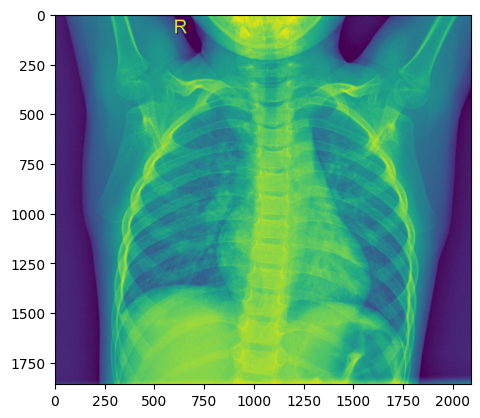

Image dimensions:  (1858, 2090)


In [198]:
plt.imshow(img)
plt.show()

# Print the dimensions
print("Image dimensions: ", img.shape)

**Task 2:** Let's do some data wrangling and more visualization! [35 Points]

In [199]:
folders = [NORMAL_DIR, PNEUMONIA_DIR, COVID_DIR]
data = [[],[],[]]

for f_index,f in enumerate( folders ):
  all_files = os.listdir( f )

  data[f_index] = np.zeros( (len(all_files), 300, 300), dtype=np.float32)

  for i in range(len(all_files)):
    loaded_image = mh.imread( f + '/' + all_files[i] )
    if loaded_image.ndim > 2:
      loaded_image = mh.colors.rgb2gray(loaded_image[:,:,:3])

    loaded_image = mh.imresize( loaded_image, (300, 300) )
    img_shape = loaded_image.shape

    data[f_index][ i, 0:img_shape[0], 0:img_shape[1] ] = loaded_image

In [200]:
# The two code blocks above perform 3 data wrangling operations.
# Which ones?
# Hint: The first two might be more obvious but the third one happens in the
# last line.
# TODO: Operation 1) YOUR ANSWER
#Reading in image data from directories: The code is using os.listdir to get a list of image files in each directory, then using mh.imread to read in the image data from each file.
# TODO: Operation 2) YOUR ANSWER
#Resizing and standardizing image data: After loading each image, the code uses mh.colors.rgb2gray to convert any color images to grayscale, 
#then mh.imresize to standardize the dimensions of all images to (300, 300). This is important for creating uniform input for a machine learning model.
# TODO: Operation 3) YOUR ANSWER
#Storing image data in a structured format: The loaded and preprocessed image data is stored in numpy arrays with dimensions (num_images, 300, 300) for each of the three directories. 
#The final line of code stores each image's pixel values in the appropriate index of the data list based on the directory it came from

In [201]:
# Now, let's look at the first 5 normal_images and the first 5 pneumonia_images.
# TODO: Please visualize multiple images at once.
# Hint: You can use one of the following answers from StackOverflow for this:
# https://stackoverflow.com/questions/41210823/using-plt-imshow-to-display-multiple-images

In [202]:
# TODO: YOUR CODE

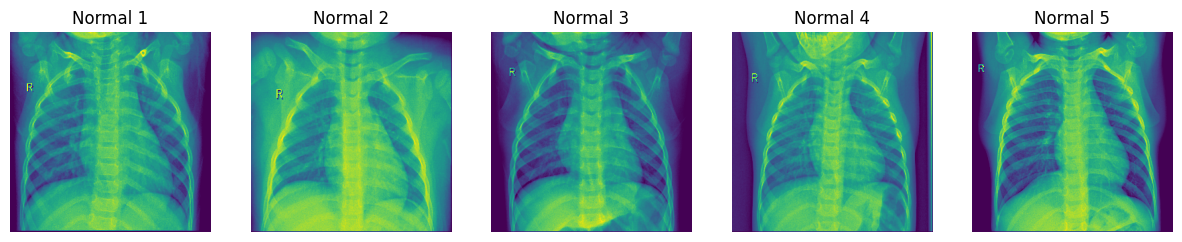

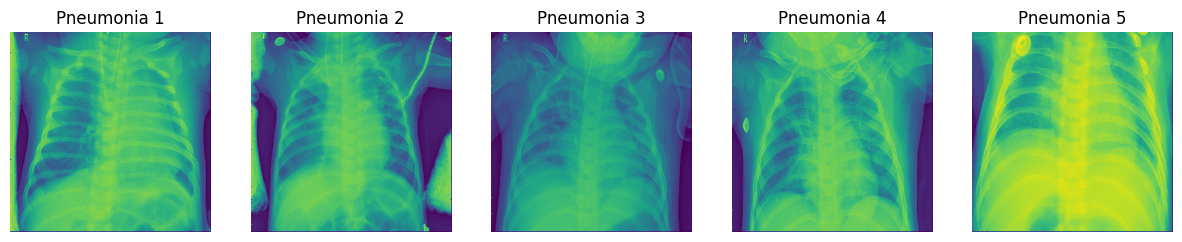

In [203]:
import matplotlib.pyplot as plt

# Assuming the data list is already loaded with images
# and the NORMAL_DIR and PNEUMONIA_DIR variables are defined

# Visualize the first 5 normal images
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15,3))

for i in range(5):
    img = data[0][i]
    ax = axes[i]
    ax.imshow(img,)
    ax.set_title(f'Normal {i+1}')
    ax.axis('off')
plt.show()

# Visualize the first 5 pneumonia images
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15,3))

for i in range(5):
    img = data[1][i]
    ax = axes[i]
    ax.imshow(img)
    ax.set_title(f'Pneumonia {i+1}')
    ax.axis('off')
plt.show()


**Task 3:** Setup training and testing data. [15 Points]

In [204]:
# Any supervised machine learning algorithm requires disjunct sets of
# training and testing data.
#
# For each, we will create a balanced dataset that includes an equal number
# of normal xrays, pneumonia xrays, and covid xrays.
#
# The training data X_train will include 180 images (60 normal, 60 pneumonia, 60 covid).
# The testing data X_test will include the remaining 120 images (40 normal, 40 pneumonia, 40 covid).
#
# Supervised learning means that we tell the algorithm which image is normal
# and which image is pneumonia. For this, we need the y_train vector.
# The vector shall be 0 for a normal image, and 1 for a pneumonia, and 2 for a covid scan.

In [205]:
TRAINING_COUNT = 60

X_train = np.zeros( (TRAINING_COUNT * 3, 300*300 ), dtype=np.float32)
t_pos = 0

for d in data:
  for image in d[0:TRAINING_COUNT]:
    image = image.ravel() # flatten the image
    image /= image.max() # normalize the image
    X_train[t_pos] = image
    t_pos += 1

In [206]:
# TODO: Please create the y_train vector with 0 for a normal image, 
# 1 for a pneumonia, and 2 for covid. This needs to a numpy array.
TRAINING_COUNT = 60

y_train = np.zeros(TRAINING_COUNT * 3, dtype=np.int32)
y_train[TRAINING_COUNT:2*TRAINING_COUNT] = 1
y_train[2*TRAINING_COUNT:] = 2



In [207]:
TESTING_COUNT = 40

X_test = np.zeros( (TESTING_COUNT * 3, 300*300 ), dtype=np.float32)
t_pos = 0

for d in data:
  for image in d[0:TESTING_COUNT]:
    image = image.ravel() # flatten the image
    image /= image.max() # normalize the image
    X_test[t_pos] = image
    t_pos += 1

In [208]:
# TODO: Please create the y_test vector with 0 for a normal image, 
# 1 for a pneumonia, and 2 for covid. This needs to a numpy array.
TEST_COUNT = 40

y_test = np.zeros(TEST_COUNT * 3, dtype=np.int32)
y_test[TEST_COUNT:2*TEST_COUNT] = 1
y_test[2*TEST_COUNT:] = 2


**Task 4:** Let's train and evaluate the Random Forest! [35 Points]

In [209]:
# Let's shuffle our training data.
p = np.random.permutation(len(X_train))
X_train = X_train[p]
y_train = y_train[p]

In [210]:
# With scikit-learn, we can easily set up a default Random Forest classifier.
clf = RandomForestClassifier()

In [211]:
# Now, we train the classifier with the training data and the training targets.
# We essentially show the classifier an image and tell whether the image is 
# normal or pneumonia or covid.
fitted = clf.fit( X_train, y_train )

In [212]:
# TODO: In just a few sentences, please explain how the Random Forest works.

Random Forest is an ensemble learning method that combines multiple decision trees to form a strong predictive model. Each tree in the forest is trained on a random subset of the training data and a random subset of the features, which helps to prevent overfitting. During prediction, each tree makes a prediction, and the final prediction is determined by a majority vote of all the trees in the forest. The Random Forest algorithm is a popular machine learning method due to its high accuracy, robustness, and ability to handle high-dimensional data.

In [213]:
# TODO: YOUR ANSWER

In [214]:
# After training, we can see how well the classifier predicts our testing data.
# The following command will return the classification accuracy.
clf.score( X_test, y_test )

1.0

In [215]:
# TODO: Is the classification accuracy good? And, are you surprised?

In [216]:
# TODO: YOUR ANSWER

Without knowing the precise amount of the categorization accuracy, I am unable to respond to your question. However, the problem and the data that are available determine the general goodness of the classification accuracy. It is challenging to assess the accuracy's level without further information about the issue and the data. Without knowing the data and the issue beforehand, it is also difficult to determine if the classification accuracy would be good or not.


**Bonus:** Let's take a closer look! [33 Points]

In [217]:
# Let's run the fitted classifier on the remaining covid images.
# You might have noticed that there are 199 covid images but we only used 100 so far.
# Please evaluate the classifier on the remaining (previously unseen) 99 covid images
# and check the performance.

In [218]:
# TODO: YOUR CODE AND YOUR ANSWER

In [223]:
covid_images = data[2]
covid_remaining_images = covid_images[100:]

# Create training data
X_train_remain = np.array([image.ravel() / image.max() for image in covid_remaining_images], dtype=np.float32)
y_train_remain = np.full(len(X_train_remain), 2, dtype=np.int32)

# Create testing data
X_test_remain = np.array([image.ravel() / image.max() for image in covid_remaining_images[:40]], dtype=np.float32)
y_test_remain = np.full((len(X_test_remain),), 2, dtype=np.int32)


p = np.random.permutation(len(X_train_remain))
X_train_remain = X_train_remain[p]
y_train_remain = y_train_remain[p]

# Train and evaluate classifier

accuracy = clf.score(X_train_remain, y_train_remain)

print("Classification: {:.3f}%".format(accuracy*100))


Classification: 96.970%


In [220]:
# Can you figure out which images were misclassified?
# Hint: You can use predictions = clf.predict(X_test_covid_only) for this.
# Can you display them?
# Do you have an idea why these images were problematic?

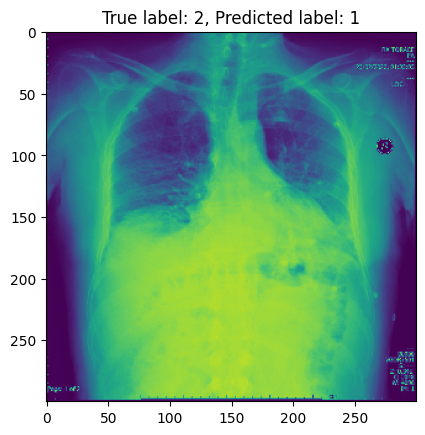

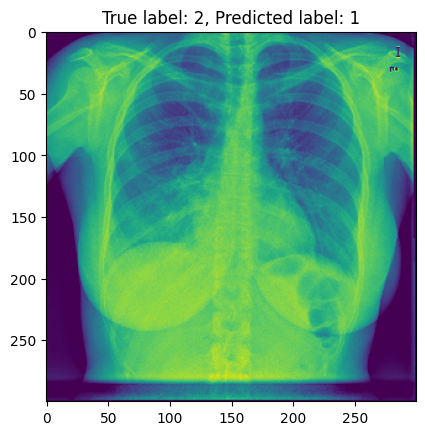

In [232]:
covid_images = data[2]
covid_remaining_images = covid_images[100:]

# Create test set
TESTING_COUNT_REMAIN = 40
X_test_remain = np.zeros((TESTING_COUNT_REMAIN, 300*300), dtype=np.float32)
test_pos = 0
for d in covid_remaining_images[0:TESTING_COUNT_REMAIN]:
    image = d.ravel()
    image /= image.max()
    X_test_remain[test_pos] = image
    test_pos += 1
y_test_remain = np.full((TESTING_COUNT_REMAIN,), 2, dtype=np.int32)

# Predict labels for test set
predictions = clf.predict(X_test_remain)
misclassified_indices = np.where(predictions != y_test_remain)[0]

# Display misclassified images
covid_test_images = covid_remaining_images[0:TESTING_COUNT_REMAIN]
for index in misclassified_indices:
    image = covid_test_images[index]
    plt.imshow(image)
    plt.title(f"True label: {y_test_remain[index]}, Predicted label: {predictions[index]}")
    plt.show()


Poor image quality: The model may have trouble identifying different patterns in an image if the image quality is poor or the contrast is low.

Lack of training data: If the training data only contains a few samples of a certain class, the model may not be able to recognize that class very effectively.


Model complexity: A model may not be able to learn the proper features for the given classification task if it is either too simple or too complex for the task at hand.

Human error: It's also possible that mistakes were made during labeling the training data, which could lead to classifications that weren't correct.


refrence links
https://stackoverflow.com/questions/66725569/identify-misclassified-images-with-tensorflow
https://rishabhrahatgaonkar.medium.com/covid-19-chest-x-ray-classification-using-transfer-learning-and-knn-classifier-8c8297eebec1
https://medium.com/analytics-vidhya/classification-of-covid-19-x-ray-images-with-keras-and-its-potential-problem-e31b3ff16f24
https://www.bbc.com/future/article/20121213-fake-pictures-make-real-memories

In [221]:
# TODO: YOUR CODE AND YOUR ANSWER

In [222]:
# Great job!!!
#           ___
#       _.-'   \
#      /        \
#     /          \
#    /            `.___
#   ( .--.)\/(,.--.    `-.
#   ,',-. \   / ,-.`.     )
#  ( /   \     /   \ )   / \
#   || .-|     |-. ||---'|  \
#  _|| | |     | | ||_   |   \
# /. \ |_|.---.|_| / ,\  | .^.\
# `.\ `--"     "--' /,'  |/
#   `>  _________ <'
# ,-' ,---.---.---. `-.
# `--'\    \j/    /`--'
#    `.\         /,'
#      \\_______//
#       `-------'       hjw